In [32]:
import argparse
import copy
import itertools
import logging
import math
import os
import random
import shutil
import warnings
from contextlib import nullcontext
from pathlib import Path

import numpy as np
import torch
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import DistributedDataParallelKwargs, ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
from huggingface_hub.utils import insecure_hashlib
from peft import LoraConfig, set_peft_model_state_dict
from peft.utils import get_peft_model_state_dict
from PIL import Image, ImageDraw
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms.functional import crop
from tqdm.auto import tqdm
from transformers import CLIPTokenizer, PretrainedConfig, T5TokenizerFast

import diffusers
from diffusers import (
    AutoencoderKL,
    FlowMatchEulerDiscreteScheduler,
    FluxFillPipeline,
    FluxTransformer2DModel,
)
from diffusers.utils import load_image
from diffusers.optimization import get_scheduler
from diffusers.training_utils import (
    _set_state_dict_into_text_encoder,
    cast_training_params,
    compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3,
    free_memory,
)
from diffusers.utils import (
    check_min_version,
    convert_unet_state_dict_to_peft,
    is_wandb_available,
)
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.torch_utils import is_compiled_module

In [36]:
from typing import Any, Callable, List, Optional, Tuple, Union
import PIL

In [62]:
logger = get_logger(__name__)

In [37]:
instance_data_root = Path("./sks")

In [38]:
paths = [path for path in list(Path(instance_data_root).iterdir())]

In [52]:
paths

[PosixPath('sks/005.jpg'),
 PosixPath('sks/001.jpg'),
 PosixPath('sks/004.jpg'),
 PosixPath('sks/001.txt'),
 PosixPath('sks/002.jpg'),
 PosixPath('sks/001_mask.png'),
 PosixPath('sks/.ipynb_checkpoints'),
 PosixPath('sks/002.txt'),
 PosixPath('sks/003.jpg'),
 PosixPath('sks/003_mask.png')]

In [53]:
type(paths[0])

pathlib.PosixPath

In [40]:
name_to_mask = {}
name_to_image = {}
name_to_prompt = {}

mask_postfix = "_mask"

for path in sorted(paths):
    file_name_with_ext = path.name
    file_name, ext = os.path.splitext(file_name_with_ext)
    if file_name.lower().endswith(mask_postfix):
        name_to_mask[file_name[:-len(mask_postfix)]] = path
    elif ext.lower() == ".txt":
        name_to_prompt[file_name] = path
    else:
        name_to_image[file_name] = path
            

In [41]:
name_to_mask

{'001': PosixPath('sks/001_mask.png'), '003': PosixPath('sks/003_mask.png')}

In [42]:
name_to_image

{'.ipynb_checkpoints': PosixPath('sks/.ipynb_checkpoints'),
 '001': PosixPath('sks/001.jpg'),
 '002': PosixPath('sks/002.jpg'),
 '003': PosixPath('sks/003.jpg'),
 '004': PosixPath('sks/004.jpg'),
 '005': PosixPath('sks/005.jpg')}

In [43]:
name_to_prompt

{'001': PosixPath('sks/001.txt'), '002': PosixPath('sks/002.txt')}

In [55]:
def generate_full_mask(size):
    mask = Image.new("L", size, 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle((0, 0, size[0], size[1]), fill=255)
    return mask

In [56]:
def load_mask_image(image: Union[str, PIL.Image.Image]) -> PIL.Image.Image:
    return load_image(image).convert("L")

In [64]:
instance_prompt = "a sks dog"
instance_images = []
pil_images = []
mask_images = []
custom_instance_prompts = []
pixel_values = []

for name in sorted(name_to_image):
    try:
        instance_image = load_image(str(name_to_image[name]))
        
        if name in name_to_mask:
            mask_image = load_mask_image(str(name_to_mask[name]))
        else:
            mask_image = generate_full_mask(instance_image.size)
            
            
        if name in name_to_prompt:
            with open(name_to_prompt[name], "r") as prompt_file:
                prompt_text = prompt_file.read()
                custom_instance_prompts.append(prompt_text)
        else:
            custom_instance_prompts.append(instance_prompt)

        instance_images.append(instance_image)
        mask_images.append(mask_image)
        
    except (IOError, AttributeError, ValueError) as e:
        print(e)

Incorrect path or URL. URLs must start with `http://` or `https://`, and sks/.ipynb_checkpoints is not a valid path.


In [65]:
instance_images

[<PIL.Image.Image image mode=RGB size=1815x1967>,
 <PIL.Image.Image image mode=RGB size=2469x2558>,
 <PIL.Image.Image image mode=RGB size=2796x2656>,
 <PIL.Image.Image image mode=RGB size=2476x2612>,
 <PIL.Image.Image image mode=RGB size=2732x2736>]

In [66]:
mask_images

[<PIL.Image.Image image mode=L size=1815x1967>,
 <PIL.Image.Image image mode=L size=2469x2558>,
 <PIL.Image.Image image mode=L size=2796x2656>,
 <PIL.Image.Image image mode=L size=2476x2612>,
 <PIL.Image.Image image mode=L size=2732x2736>]

In [67]:
custom_instance_prompts

['sks dog,tongue',
 'sks dog licking his lip',
 'a sks dog',
 'a sks dog',
 'a sks dog']

In [68]:
size = 1024
center_crop = False
train_resize = transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR)
train_crop = transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size)
train_flip = transforms.RandomHorizontalFlip(p=1.0)
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [73]:
pil_images = []
for image in instance_images:
    image = exif_transpose(image)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = train_resize(image)
    pil_images.append(image.copy())
    image = train_transforms(image)
    pixel_values.append(image)

In [77]:
def prepare_mask_and_masked_image(image, mask):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    mask = mask[None, None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)
    
    return mask, masked_image

In [91]:
image_new = train_resize(instance_images[0])

In [92]:
image_new.size

(1024, 1109)

In [80]:
mask, masked_image = prepare_mask_and_masked_image(instance_images[0], mask_images[0])

In [81]:
mask.shape

torch.Size([1, 1, 1967, 1815])

In [82]:
masked_image.shape

torch.Size([1, 3, 1967, 1815])

In [83]:
masked_image = masked_image.numpy()
masked_image = masked_image[0].transpose(1, 2, 0)
masked_image = (masked_image + 1.0) * 127.5

In [84]:
masked_image = np.clip(masked_image, 0, 255).astype(np.uint8) 

In [85]:
image = Image.fromarray(masked_image)

In [86]:
mask.shape

torch.Size([1, 1, 1967, 1815])

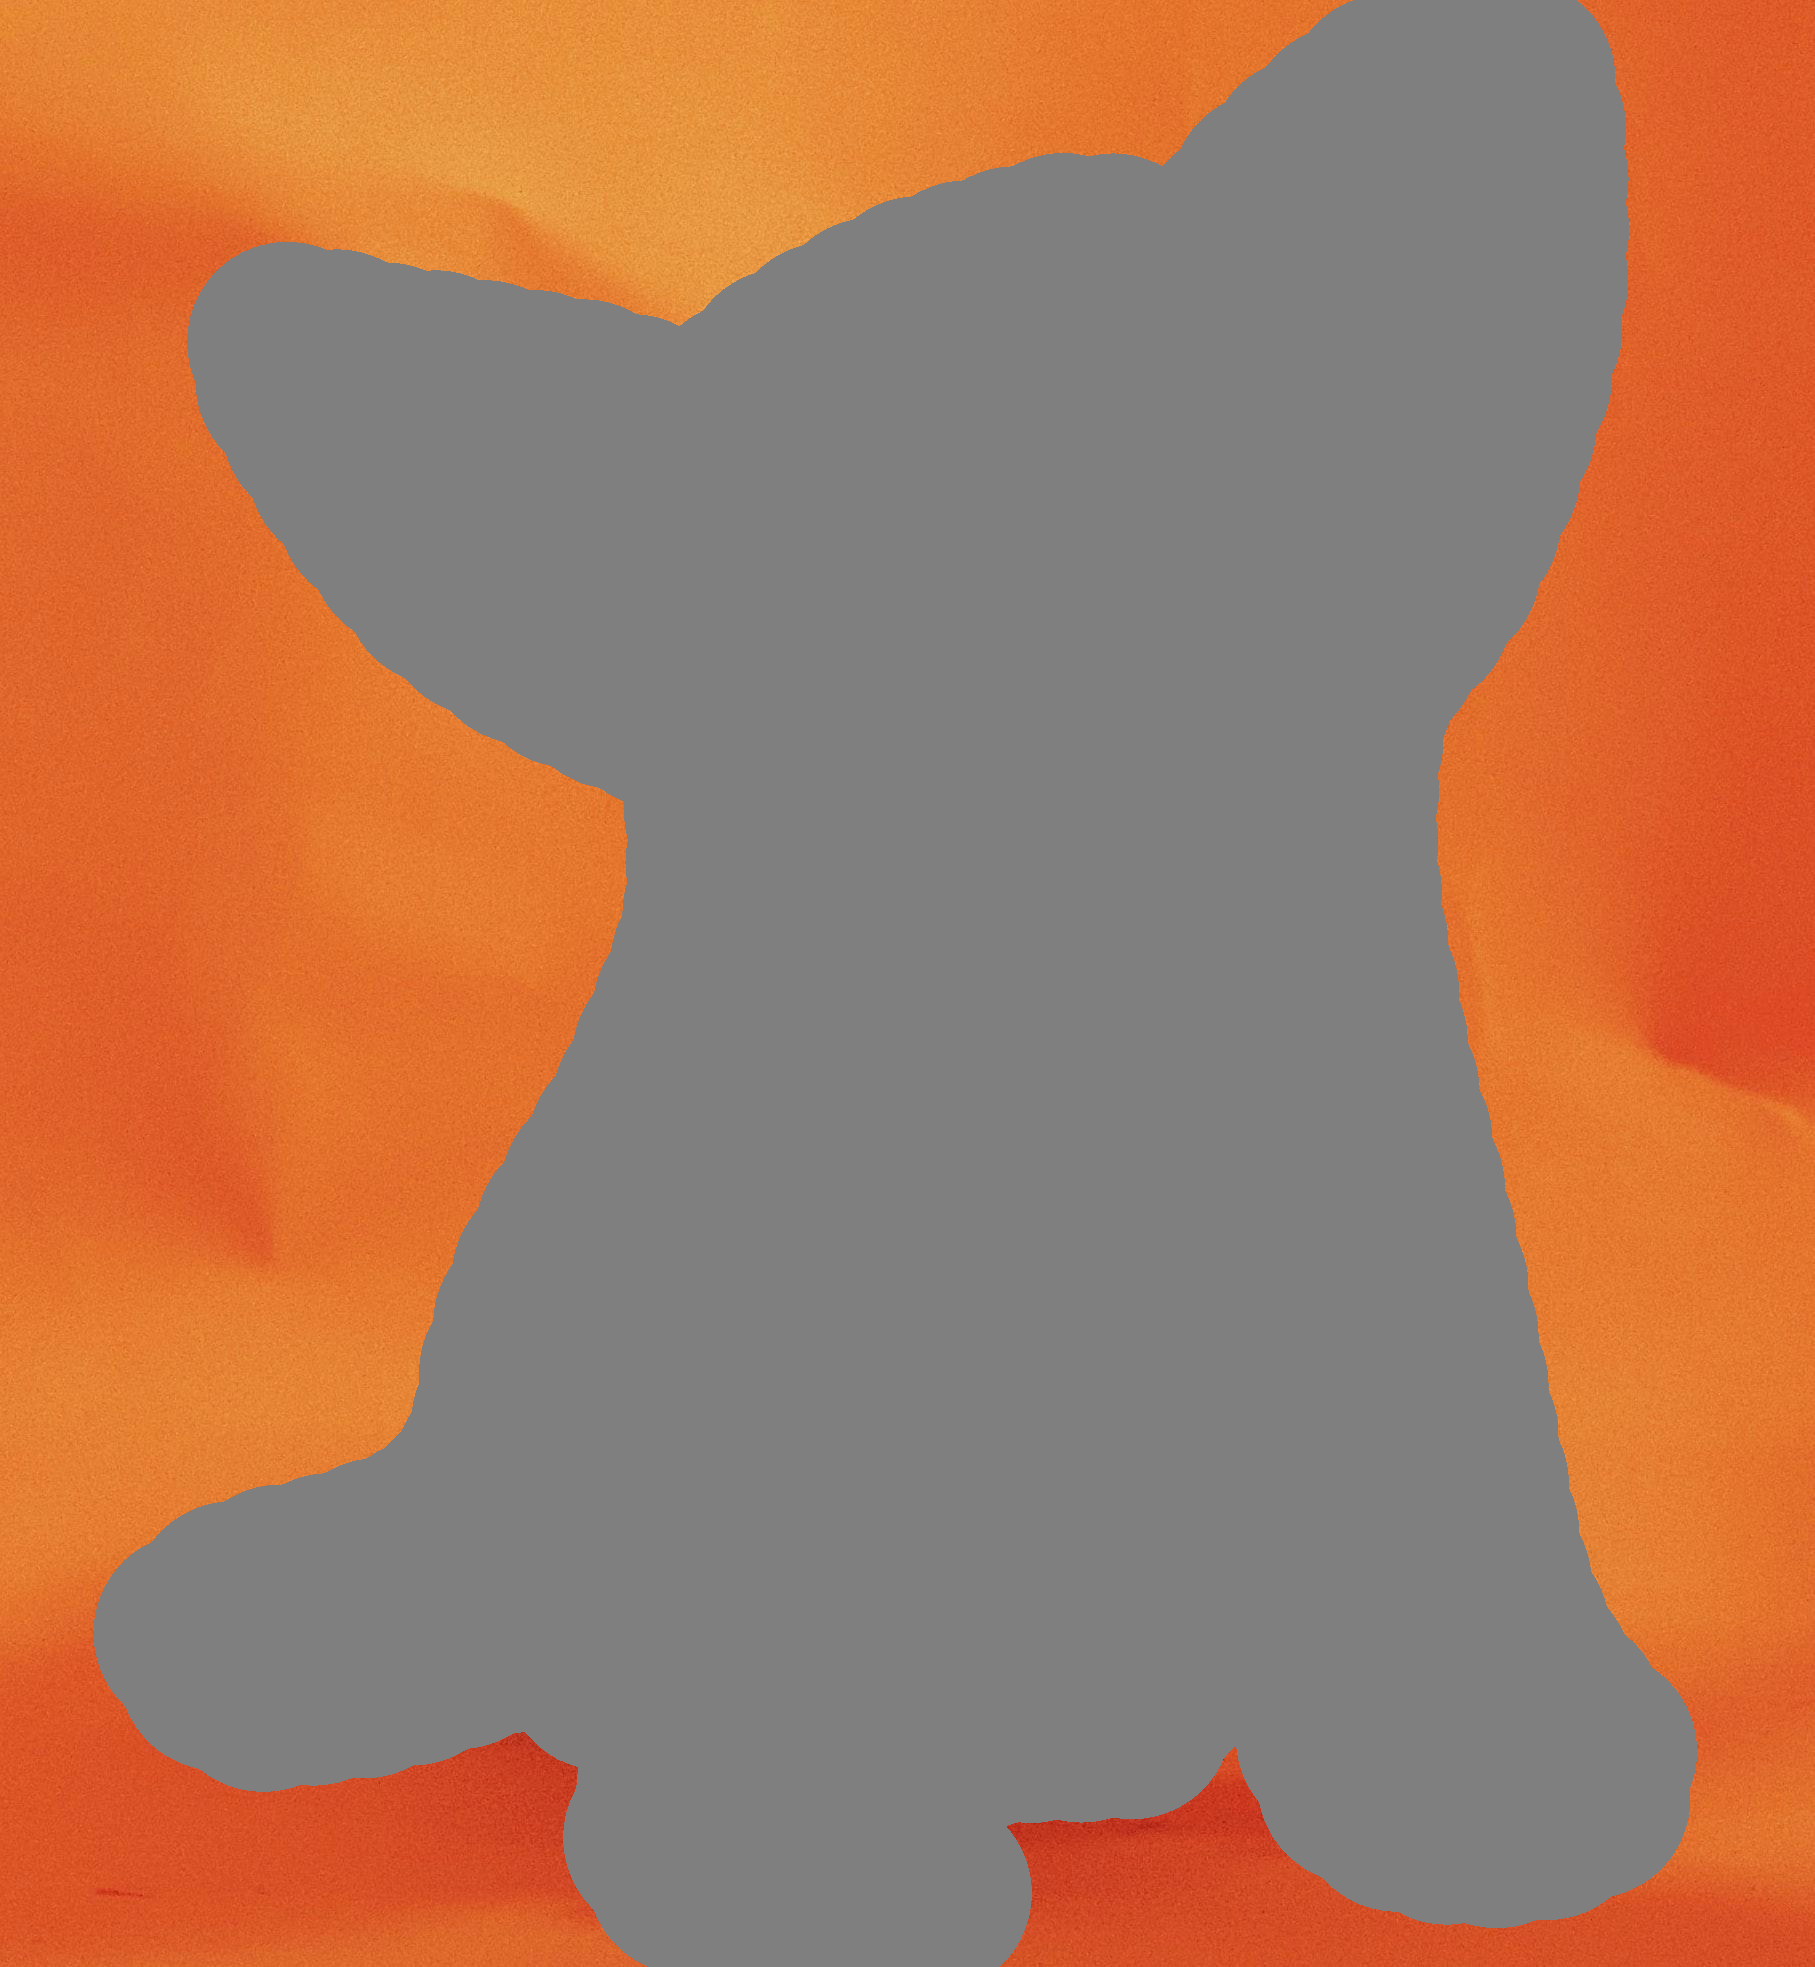

In [88]:
image

In [89]:
transforms.Resize(1024)

Resize(size=1024, interpolation=bilinear, max_size=None, antialias=True)

In [90]:
images

NameError: name 'images' is not defined

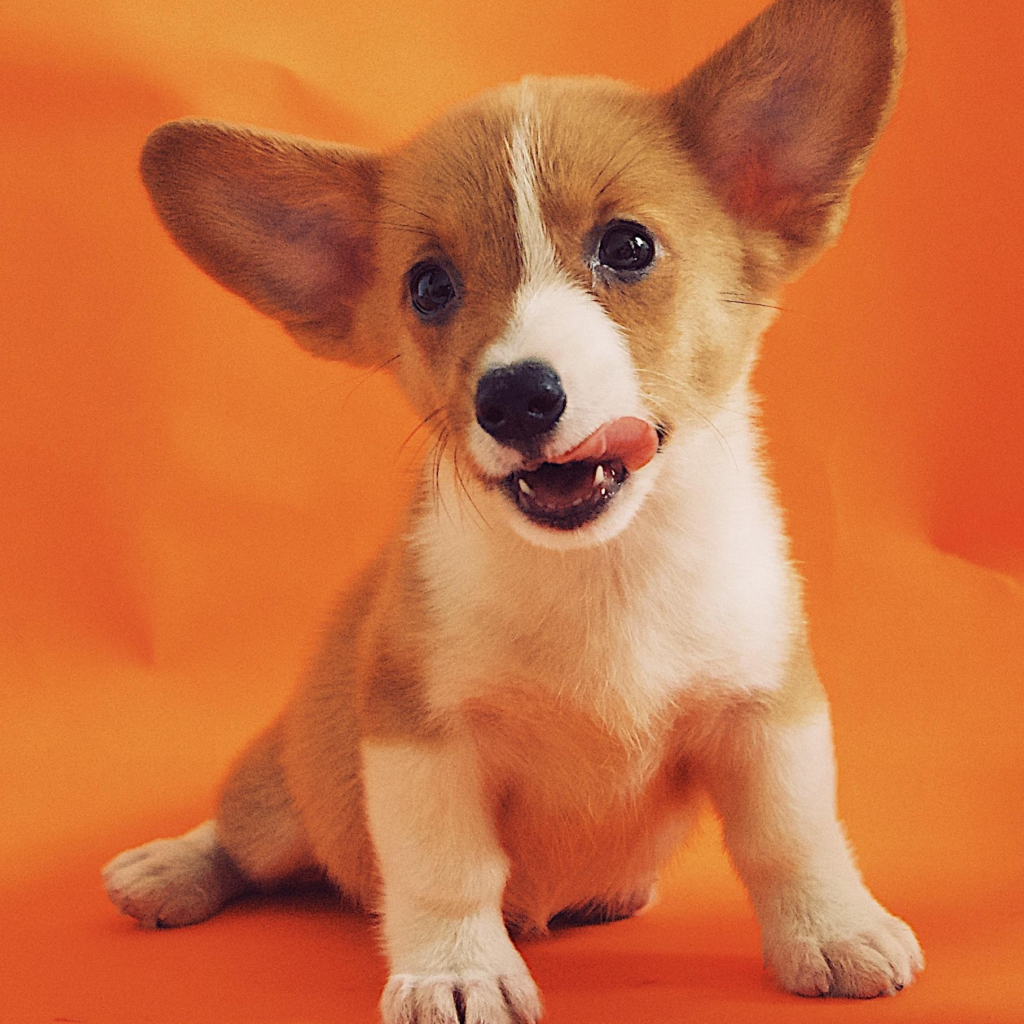

In [100]:
train_crop(image_new)

In [101]:
print(image_new)

<PIL.Image.Image image mode=RGB size=1024x1109 at 0x7F8DB6651700>


In [102]:
a = [1,2,3]

In [103]:
a *= 4

In [104]:
a

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]

In [111]:
torch.randint(0, 9, (1,)).item()

5